### https://github.com/ewenme/transfers/blob/master/src/functions.R

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from highlight_text import fig_text
import numpy as np
from matplotlib import pyplot as plt

spaceMono_bold = 'https://github.com/googlefonts/spacemono/blob/main/fonts/SpaceMono-BoldItalic.ttf?raw=true'

from mplsoccer import FontManager
from matplotlib.colors import LinearSegmentedColormap

monoBFont = FontManager(spaceMono_bold)

In [5]:
urls = [
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2021",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2020",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2019",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2018",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2017",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2016",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2015",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2014",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2013",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2012",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2011",
    "https://www.transfermarkt.com/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2010"
]
dfs = []
for i,url in enumerate(urls):
    page = requests.get(url, headers={'User-Agent': 'Custom'})
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find(class_="grid-view", id="yw1")
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) 
    df = pd.DataFrame(data)
    df = df[df.columns[0:6]] 
    df.columns = ["club","squad","ave_age","foreign_players","ave_mkt_value","total_mkt_value"]
    try:
        season = urls[i].split("=")[1]
    except:
        season = "2022"
    df["season"] = season
    dfs.append(df)

AttributeError: 'NoneType' object has no attribute 'find'

In [3]:
urls = [
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2021&saison_id_bis=2021&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2020&saison_id_bis=2020&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2019&saison_id_bis=2019&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2018&saison_id_bis=2018&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2017&saison_id_bis=2017&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2016&saison_id_bis=2016&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0",
    "https://www.transfermarkt.com/laliga/einnahmenausgaben/wettbewerb/ES1/plus/0?ids=a&sa=&saison_id=2015&saison_id_bis=2015&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0"  
]
dfs = []
season = 2022
for i,url in enumerate(urls):
    page = requests.get(url, headers={'User-Agent': 'Custom'})
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find(class_="grid-view", id="yw1")
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) 
    df = pd.DataFrame(data)
    df = df[df.columns[0:7]] 
    df.columns = ["idx","club","expenditure","arrivals","income","departures","balance"]
    df.drop(columns=["idx"],inplace=True)
    df["season"] = season
    season -= 1
    dfs.append(df)

In [42]:
df = pd.concat(dfs)
df.sort_values(by="season",inplace=True)
df

,club,expenditure,arrivals,income,departures,balance,season
19,Sporting Gijón,-,9,-,11,+-0,2015
0,Valencia CF,€143.90m,25,€50.00m,18,€-93.90m,2015
1,Atlético de Madrid,€119.00m,35,€152.00m,24,€33.00m,2015
2,Real Madrid,€92.90m,21,€32.65m,12,€-60.25m,2015
3,FC Barcelona,€51.00m,15,€38.30m,10,€-12.70m,2015
...,...,...,...,...,...,...,...
17,Girona FC,€4.50m,20,-,22,€-4.50m,2022
18,CA Osasuna,€2.00m,13,-,12,€-2.00m,2022
19,Athletic Bilbao,-,19,-,12,+-0,2022
10,Elche CF,€12.96m,18,€5.50m,16,€-7.46m,2022


In [43]:
cols= ["expenditure", "income", "balance"]
for col in cols:
    if col == "expenditure":
        df[col]= df[col].str.replace('.', '') \
                    .str.replace("-","0") \
                    .str.replace('€', "-") \
                    .str.replace("m","0000") \
                    .str.replace("Th","000") \
                    .str.replace("bn","0000000") \
#                     .astype('float')
    else:
        df[col]= df[col].str.replace('.', '') \
                    .str.lstrip('€') \
                    .str.replace("m","0000") \
                    .str.replace("Th","000") \
                    .str.replace("bn","0000000") \
#                     .astype('float')

<ipython-input-43-7c9cb69a4622>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace('.', '') \
<ipython-input-43-7c9cb69a4622>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace('.', '') \


In [44]:
team = "`"

val = df[df["club"]==team][cols[2]].values
balance_colors = []
for v in val:
    if float(v) < 0:
        balance_colors.append("red")
    else:
        balance_colors.append("#6FEDD6")    
print(val)
balance_colors

['33000000' '-34800000' '8400000' '-110100000' '61650000' '-7700000'
 '-53950000' '-19550000']


['#6FEDD6', 'red', '#6FEDD6', 'red', '#6FEDD6', 'red', 'red', 'red']

In [45]:
df[df["club"]==team]

,club,expenditure,arrivals,income,departures,balance,season
1,Atlético de Madrid,-119000000,35,152000000,24,33000000,2015
2,Atlético de Madrid,-78800000,35,44000000,21,-34800000,2016
1,Atlético de Madrid,-95600000,23,104000000,21,8400000,2017
0,Atlético de Madrid,-168000000,28,57900000,19,-110100000,2018
2,Atlético de Madrid,-247350000,25,309000000,20,61650000,2019
1,Atlético de Madrid,-91000000,22,83300000,17,-7700000,2020
0,Atlético de Madrid,-76700000,30,22750000,19,-53950000,2021
5,Atlético de Madrid,-26500000,27,6950000,19,-19550000,2022


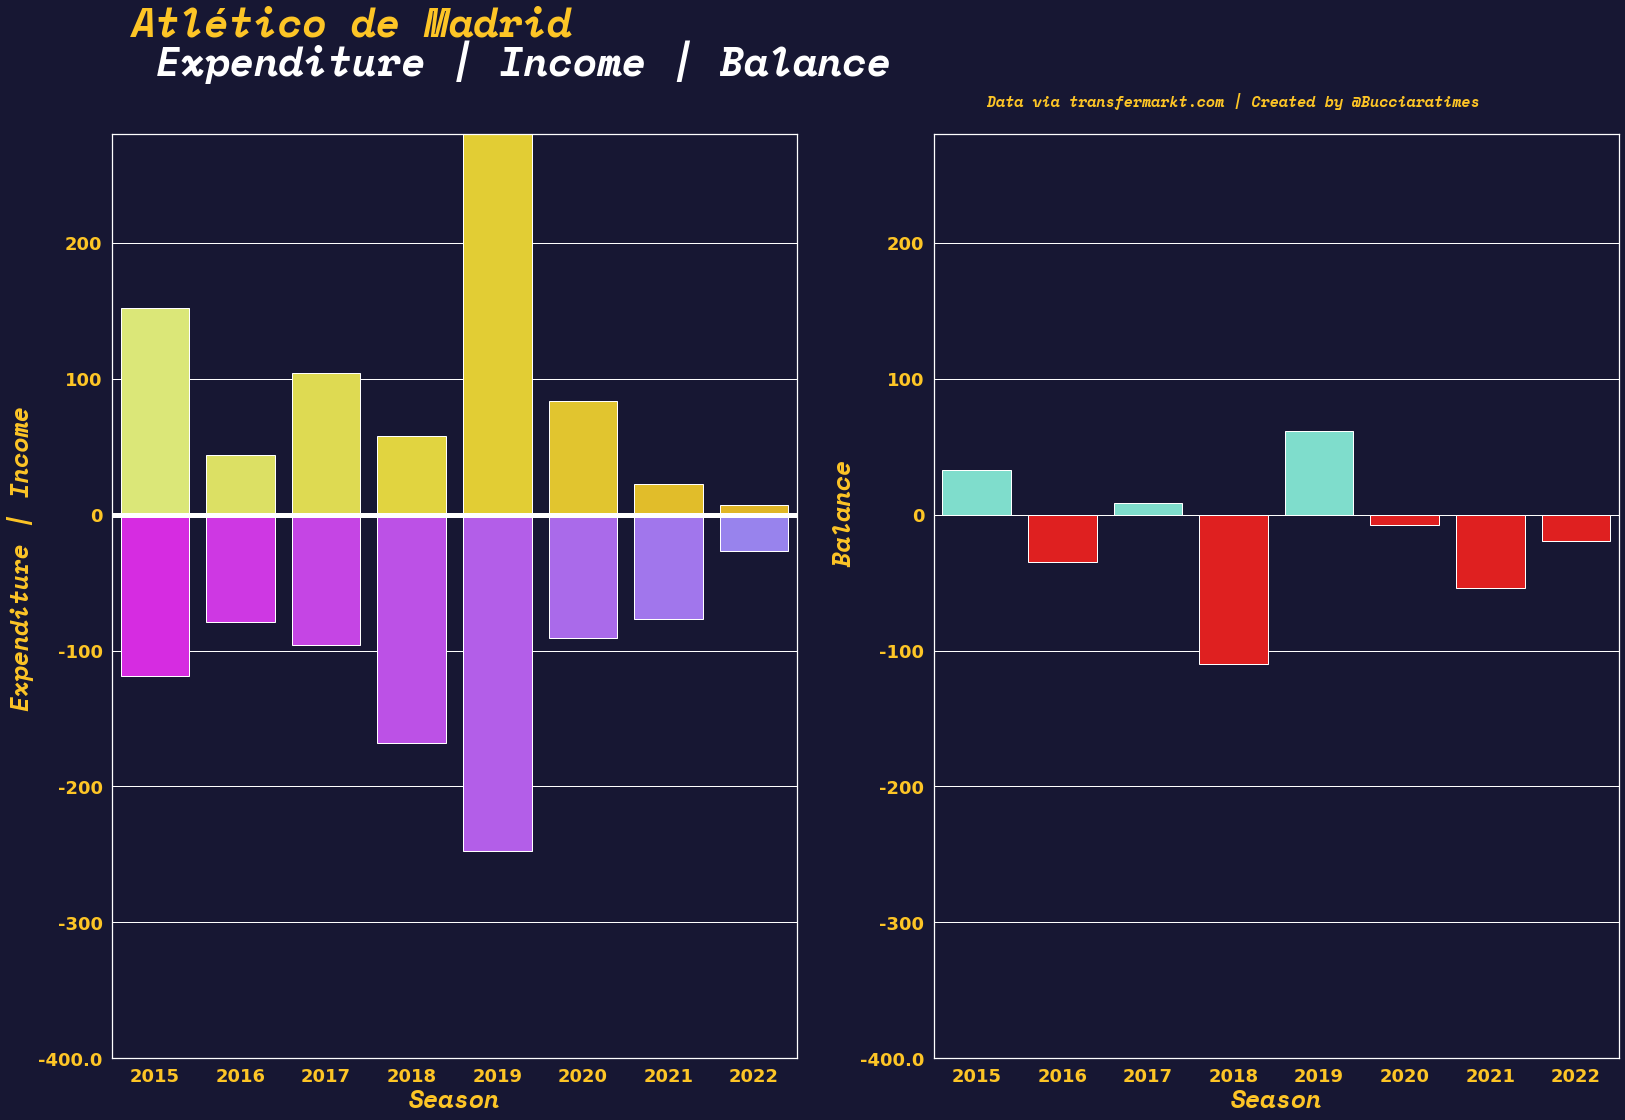

In [52]:
sns.set(style="darkgrid")
fig,axes = plt.subplots(1,2,figsize=(27,17))
fig_color = "#171733"
fig.set_facecolor(fig_color)
axes = axes.flatten()

axes[0].hlines(y=0, xmin=-50000000, xmax=150000000, colors="white", linewidth=5)
expenditure = sns.barplot(x="season", y=cols[0], orient="v", data=df[df["club"]==team], palette=sns.color_palette("cool_r", 17), ax=axes[0])
income = sns.barplot(x="season", y=cols[1], orient="v", data=df[df["club"]==team], palette=sns.color_palette("Wistia", 17),ax=axes[0])
balance = sns.barplot(x="season", y=cols[2], orient="v", data=df[df["club"]==team], palette=balance_colors,ax=axes[1])

axes[0].set_ylabel("     Expenditure | Income",fontweight='bold',fontsize=25,color="#fdc526",fontproperties=monoBFont.prop)   
axes[1].set_ylabel("           Balance",fontweight='bold',fontsize=25,color="#fdc526",fontproperties=monoBFont.prop)   

for i in range(len(axes)):
    axes[i].set_ylim((-400000000,280000000))
    axes[i].set_facecolor(fig_color)
    axes[i].set_xlabel("Season",fontsize=25,fontweight='bold',color="#fdc526",fontproperties=monoBFont.prop)
    axes[i].set_yticklabels([-400.  , -300, -200,  -100,   0,  100,  200, 300.  ])
    for xlabel,ylabel in zip(axes[i].get_xticklabels(),axes[i].get_yticklabels()):
        xlabel.set_fontsize(18)
        xlabel.set_color("#fdc526")
        xlabel.set_fontweight("bold")
        ylabel.set_fontsize(18)
        ylabel.set_color("#fdc526")
        ylabel.set_fontweight("bold")


fig_text(s=f"<{team}> \n {cols[0].title()} | {cols[1].title()} | {cols[2].title()}",
         x=axes[0].get_position().x0+.01,y=axes[0].get_position().y1+0.035,
         color="#ffffff",
         highlight_colors=["#fdc526"],
         highlight_weights=["bold"],
         highlight_styles=["italic"],
         fontsize=40,
         fontproperties=monoBFont.prop,fig=fig)

fig_text(s=f"<Data via transfermarkt.com | Created by @Bucciaratimes>",
         x=axes[0].get_position().x0+0.45,y=axes[0].get_position().y1+0.02,
         color="#f8f8f8",
         highlight_colors=["#fdc526"],
         highlight_weights=["bold"],
         highlight_styles=["italic"],
         fontsize=15,
         fontproperties=monoBFont.prop,fig=fig)

plt.savefig(f'/work/output/fee_{team}.png', dpi=300, bbox_inches="tight")

In [27]:

axes[0].set_yticklabels(np.linspace(-400,280,8))

[Text(0, -400000000.0, '-400.0'),
 Text(0, -300000000.0, '-302.8571428571429'),
 Text(0, -200000000.0, '-205.71428571428572'),
 Text(0, -100000000.0, '-108.57142857142856'),
 Text(0, 0.0, '-11.428571428571445'),
 Text(0, 100000000.0, '85.71428571428567'),
 Text(0, 200000000.0, '182.8571428571429'),
 Text(0, 300000000.0, '280.0')]

In [49]:
np.round(np.linspace(-400,320,8),2)

array([-400.  , -297.14, -194.29,  -91.43,   11.43,  114.29,  217.14,
        320.  ])

[-400.0, -300, -200, -100, 0, 100, 200, 300.0]